<h1 style="text-align:center;">XGBoost: End to End</h1>

### Exoplanet Discovery with XGBoost

In this chapter, we embark on a stellar journey using XGBoost, aiming to detect exoplanets. The motivation is twofold:

1. **XGBoost Practice**: Emphasis is on gaining experience with a comprehensive study using XGBoost. This extends beyond the scope of exoplanet discovery, focusing on general strategies such as selecting appropriate scoring metrics and hyperparameter tuning, which are crucial for XGBoost's practical applications.

2. **Handling Imbalanced Data**: Mastering the handling of imbalanced datasets is a key skill for machine learning practitioners. This chapter focuses on this aspect, using XGBClassifier to analyze light data for predicting the existence of exoplanets.

#### Key Learning Outcomes

- **Searching for Exoplanets**: We'll start by reviewing historical methods of detecting exoplanets and then apply machine learning to light data for predictions.
- **Understanding Evaluation Metrics**: We'll delve into using the confusion matrix and classification report to comprehend precision and recall.
- **Data Resampling**: Techniques for resampling imbalanced data will be discussed, an essential step in ensuring accurate model performance.
- **Optimizing XGBClassifier**: Fine-tuning and scaling the XGBClassifier will be essential to handle the imbalanced dataset effectively.

#### Historical Context

- **Astronomy's Evolution**: From ancient stargazing to 17th-century telescopic advances, and 18th-century astronomical predictions, our understanding of the cosmos has evolved dramatically.
- **Exoplanet Discovery**: In the 20th century, exoplanets were found not through direct observation but by detecting dips in starlight caused by their transit, a process requiring precise light fluctuation measurements over time.

#### The Exoplanet Dataset

- **Dataset Overview**: Sourced from NASA's Kepler Space Telescope, the dataset comprises over 1.5 million entries across 300+ columns and 5,000+ rows, with a minority of stars hosting exoplanets.
- **Data Handling**: To manage this vast dataset efficiently, we'll begin with a subset, a standard approach for large datasets. This involves selecting the first few rows for initial analysis while ensuring the subset is representative.

---

Let's start exploring the dataset and apply XGBoost for our cosmic quest.

In [1]:
import os
import warnings

os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning' 

import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import (train_test_split, cross_val_score, 
                        StratifiedKFold, GridSearchCV, RandomizedSearchCV)

from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                        recall_score, ConfusionMatrixDisplay)
from zipfile import ZipFile
from time import time
from helper_file import *

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

sns.set()
warnings.filterwarnings("ignore", category=FutureWarning) 
# export PYTHONWARNINGS="ignore::FutureWarning"

`pd.read_csv` contains an `nrows` parameter, used to limit the number of rows. Note that `nrows=n` selects the first n rows of the dataset.

In [2]:
url = 'data/exoplanets.zip'

with ZipFile(url, 'r') as z:
    with z.open(z.namelist()[0]) as f:
        df = pd.read_csv(f, nrows=400)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 9.8 MB


In [3]:
df.sample(n=5, random_state=43)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
55,1,247.83,173.35,191.67,169.51,97.43,158.84,138.74,165.53,100.79,...,-25.33,-123.41,-69.55,-24.53,-65.98,-15.65,64.76,26.53,25.25,39.77
271,1,-3.93,3.78,13.18,1.41,1.70,-8.71,7.50,-2.77,-6.80,...,-2.87,4.29,-5.92,-10.97,0.49,0.73,8.06,-7.26,-5.51,1.64
390,1,-186.39,-200.57,-203.37,-207.07,-191.11,-190.57,-240.22,-189.64,-232.90,...,-3.92,-49.79,-21.93,-22.43,-43.06,-3.81,-1.12,-15.82,-24.96,41.64
105,1,67.03,86.02,80.51,96.45,103.42,107.07,118.06,109.17,113.37,...,57.20,61.67,94.63,70.82,53.50,58.02,35.54,20.95,-3.87,38.82
223,1,384.58,385.52,372.67,388.69,365.60,365.18,371.61,347.58,343.12,...,29.64,30.60,24.52,14.60,24.69,41.44,14.11,19.38,30.07,43.20


### Exoplanet Detection and Periodicity

When we're sifting through the cosmos for exoplanets, it's a bit like trying to catch a glimpse of a firefly as it flits by a lighthouse. Those 3,198 columns in our DataFrame? They're our timestamps, our individual snapshots of light, which are critical for capturing the rhythm of the heavens.

Consider our own celestial backyard for a moment. Mercury zips around the sun in a swift 88 days, while Neptune takes a leisurely 165-year stroll. To spot an exoplanet, we need our observations to be just as diligent and frequent; otherwise, we might miss the dance of a planet as it crosses its star, a cosmic game of peekaboo.

And here's where our challenge sharpens. Out of all the stars we're peering at, only 37 are known to keep the company of exoplanets. So, in our subset, we need to figure out just how many of these rare celestial gatherings we have captured. Let's roll up our sleeves and dive into the `LABEL` column to count our exoplanetary companions.

To determine the number of exoplanet stars within the subset of data, you would indeed use the `.value_counts()` method on the `LABEL` column, assuming that this column indicates whether a star has exoplanets or not (usually with binary indicators such as 1 for the presence of an exoplanet and 0 for its absence). 

The expectation is that when an exoplanet blocks light from a star, the light flux goes down. If drops in flux occur periodically, an exoplanet is likely the reason since, by definition, a planet is a large object orbiting a star.

This code snippet will give you a count of how many times each unique value appears in the `LABEL` column, effectively telling you how many stars in your subset have exoplanets and how many do not. If '1' indicates the presence of an exoplanet, the count for '1' will tell you how many exoplanet-hosting stars are in your subset.

In [4]:
(df
 ["LABEL"]
 .value_counts()
)

LABEL
1    363
2     37
Name: count, dtype: int64

In [5]:
X, y = splitX_y(df, 'LABEL')

y_recode = y.replace({1: 0, 2: 1})

X_train, X_test, y_train, y_test = train_test_split(
        X, y_recode, random_state=43)

print(f"shape of target vector: {y.shape}")
print(f"shape of feature matrix: {X.shape}")

shape of target vector: (400,)
shape of feature matrix: (400, 3197)


The code block above is what we have been using. The difference is: `y_recode = y.replace({1: 0, 2: 1})`.  The XGBClassifier will be anticipating binary classes `[0, 1]`, but will instead find `[1, 2]` in our `y_train` data. So we stop that from happening.


### Visualizing our Data

Let's put on our programming hats and conjure up a little function named `light_plot`. This handy tool will take us on a visual stroll through the data—one row at a time. Imagine you've got a bead on a distant star and you want to watch its light dance and dip, just to see if a planet might be passing by, winking at us from across the void.

Here's what `light_plot` will do: it'll grab the index of the data we're curious about, and it'll plot the light flux—our y-axis—as it flickers and fades over time, our x-axis being each of our observations.

Remember to label your axes, folks! We're scientists, after all. The x-axis will be our 'Number of Observations', and the y-axis will be 'Light Flux'. It's like putting a name tag on the light, giving us a clue about what it's up to. Let's dive into the code and light up our understanding of these distant suns and their potential planetary pals.


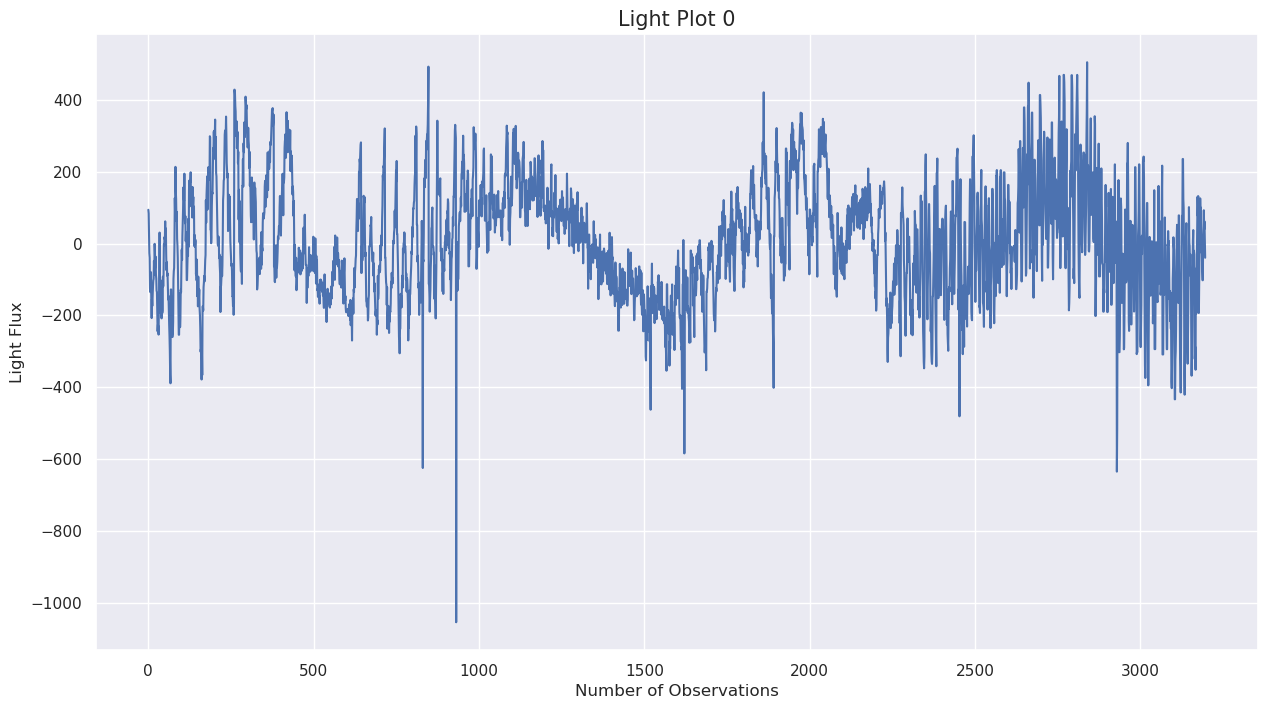

In [6]:
def light_plot(index):

    y_vals = X.iloc[index]

    x_vals = np.arange(len(y_vals))

    plt.figure(figsize=(15,8))

    plt.xlabel('Number of Observations')

    plt.ylabel('Light Flux')

    plt.title('Light Plot ' + str(index), size=15)

    plt.plot(x_vals, y_vals)

    plt.show()

light_plot(0)

Alright, let's gaze at the image above – our 'Light plot 0'. What we've got here is a cosmic dance of shadows. See those dips in the light, those soft, rhythmic pauses? They come and go like the steady beat of a drum, hinting that maybe, just maybe, there's a planet out there, taking its regular stroll in front of its star.

But don't jump to conclusions just yet! Seeing these dips alone isn't enough to shout 'Eureka!'. It's a subtle tease, a whisper of a world.

Now, switch your attention to the 37th index, where we're peeking at a star without any known exoplanets. Here the light's doing a different kind of tango – it dips and peaks with a bit more of an erratic rhythm, a jazz solo rather than our previous waltz. It's a messier pattern, not the neat, periodic signature we might hope for.

These inconsistent dips? They're like the scattered footsteps of an absent-minded wanderer, not the regular march we're looking for. With just this chart to go on, we can't confidently say there's a planet out there. It's a cosmic puzzle, and we're still putting the pieces together."

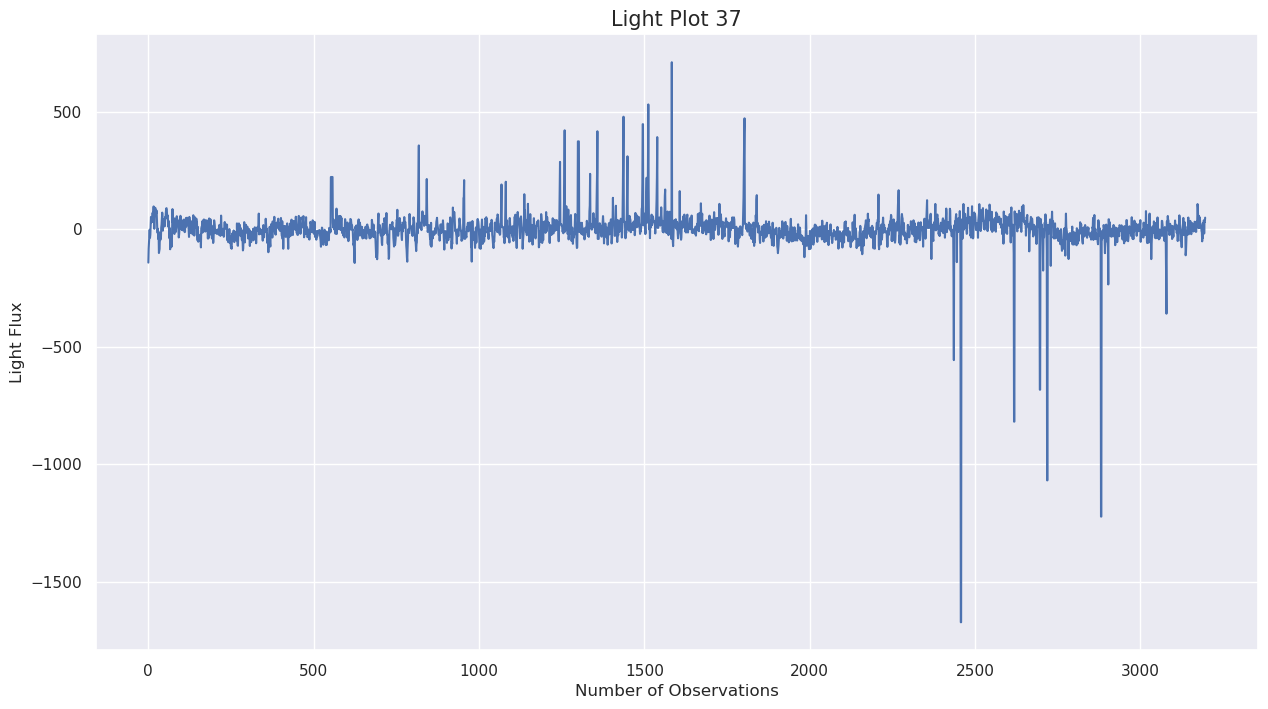

In [7]:
light_plot(37)

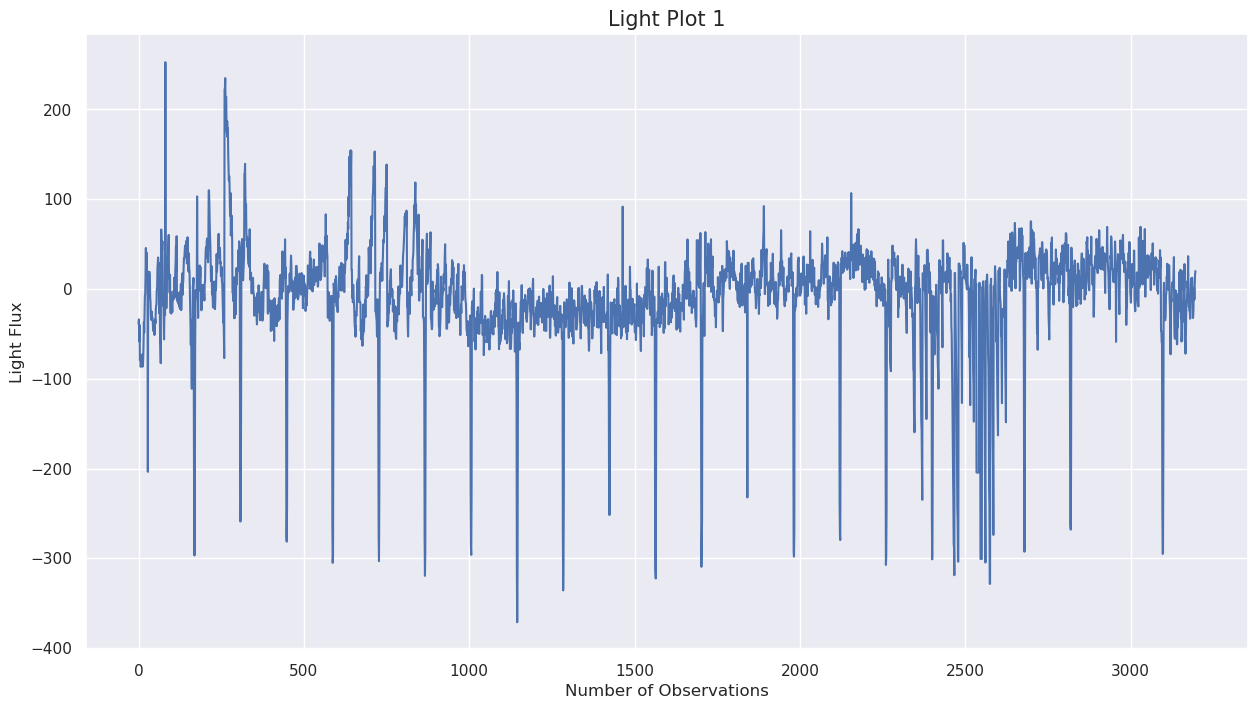

In [8]:
light_plot(1)

Peering at this plot is like watching a cosmic signal light flash its rhythmic beat across the universe. You see those grand swoops of dimming light? That's the universe's way of nodding 'yes' to the likely presence of an exoplanet. If every star's light curve was as clear as a bell, we'd have no need for the computational wizardry of machine learning.

But the universe loves a good mystery, doesn't it? Not every star's story is so easy to read. Most plots are more like a novel than a short story; they're complex, full of twists and turns, and don't give away their secrets so easily.

That's precisely why we're here—our job is to unravel these cosmic tales. While astronomers have their own bag of tricks for spotting these distant worlds, we've got a trick of our own: machine learning. It's our telescope, our mathematical magnifying glass, to bring into focus what the naked eye—or the standard scope—might miss.

Imagine we've got all these flickers of light laid out in front of us, like a Morse code from the cosmos. Now, you might think we're trying to guess the next dot or dash in the sequence, but no, that's not the game we're playing. We're not fortune tellers trying to predict the next flicker. Our mission is more like that of a cosmic detective. We want to sift through all those flickers and figure out if they're just random twinkles or the secret signals of a planet passing by a distant star.

So how do we crack this celestial code? We call in our machine learning sleuths, classifiers that are trained to spot patterns in the data—a bit like teaching your dog to fetch, but instead of sticks, they're fetching us answers about which stars might have planets orbiting them.

In this chapter, we're going to train our very own XGBClassifier, a keen-eyed detective in the world of algorithms, to help us pin the tail on the exoplanets. But before our classifier can start sniffing out exoplanets, we've got to get our data in tip-top shape. It's like lining up our evidence before presenting it to the jury. Let's roll up our sleeves and get that data ready for the show!

In [9]:
model = XGBClassifier(booster='gbtree', 
                      objective='binary:logistic', 
                      random_state=43)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)

print(f'Score: {str(score)}')

Score: 0.9


Alright, imagine you've come up with a shiny new model that says it can spot stars with exoplanets 90% of the time. Not bad, right? You might be feeling pretty smug about it. But then you take it to your astronomy professor, who's seen a dataset or two in their time. They'd raise an eyebrow and say, 'Nice try, but did you consider that if exoplanets are only around 10% of the stars, a lazy model that simply guesses 'nope, no planets here' every time would be right about 90% of the time? So, what's so special about your scores?'

And there's the rub. If you're playing a game of cosmic hide and seek, and the hiders are super rare, finding them isn't as simple as saying 'you're all good at hiding.' Because in a universe where most stars are flying solo, being right most of the time just by guessing 'loner' isn't really playing the game.

That's why in the land of imbalanced datasets, accuracy can be a tricky beast. It might be telling you that you're winning, but in reality, you might not even be playing the right game.

### Analyzing the confusion matrix
A confusion matrix is a table that summarizes the correct and incorrect predictions of a classification model. The confusion matrix is ideal for analyzing imbalanced data because it provides more information on which predictions are correct, and which predictions are wrong.

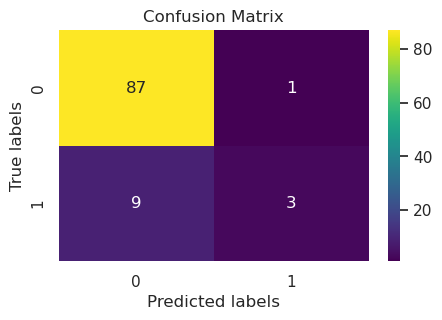

In [10]:
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn's heatmap function
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Let's say we've got this confusion matrix, which is sort of a scorecard that tells us how well our model is spotting those elusive exoplanets. Now, the numbers diagonally across this matrix are the ones our model got right. We've got 87 times where it said 'no exoplanet here' and was spot on, and 3 times where it caught an exoplanet star—like finding a needle in a haystack.

But here's where things get spicy: there's a 1 in the upper-right corner, which means our model got over-excited and cried 'exoplanet!' once when it was just empty space. And then there's a sneaky 9 in the bottom-left corner—these are the ones that got away, the actual exoplanets it missed, like mistaking a firefly for a star.

If we look at it row by row, it's like our model is a bouncer at a cosmic club. It let in 87 out of 88 non-exoplanet stars—pretty good at keeping out the riff-raff. But when it came to the VIPs, the actual exoplanet stars, it only recognized 3 out of 12. It's letting the stars of the show slip by!

This confusion matrix gives us the gossip behind the scenes, the lowdown on where our model's making friends and where it's missing out on the party. It's the nitty-gritty detail that our plain old accuracy score just glosses over.

### `classification_report`

The various percentages from the numbers revealed in the confusion matrix in the previous section are contained within a classification report. Let's view the classification report

In [11]:
print(classification_report(y_test, y_pred,))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        88
           1       0.75      0.25      0.38        12

    accuracy                           0.90       100
   macro avg       0.83      0.62      0.66       100
weighted avg       0.89      0.90      0.88       100



#### **precision**

Let's talk about precision—a little detective work to figure out when our model is really onto something. Imagine precision as the art of not crying wolf. When it hollers 'Eureka, an exoplanet!', how often is there actually one twinkling there?

So we've got these things called true positives—think of them as the gold stars we give our model when it gets it right, like spotting an exoplanet and not just blinking satellite debris.

True positives are the times our model points to a star and says, 'Yup, that's a 2, alright,' and wouldn't you know it, it actually is a 2.

But then, there's the flip side: false positives. These are the oops moments. It's like our model sees a bit of space dust and gets all excited, thinking it's found another Earth. It's when our model is betting on 2s, but they're really just 1s in disguise. It's the over-eager friend who thinks every rock is a diamond.

Precision is the measure of our model's true detective moments versus its over-eager blunders. It tells us how trustworthy our model is when it claims to have discovered another world out there.

Precision is calculated using the formula:

$$ \text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}} $$

Where:
- **True Positives (TP)** are the correctly identified positive cases.
- **False Positives (FP)** are the cases that are incorrectly identified as positive.

Precision gives the percentage of correct predictions for each target class. 

#### **recall**

Think about recall like this: It's a measure of whether we've got a net big enough to catch all the fish we want. It tells us what slice of the exoplanet pie we've managed to snag with our predictions.

So, if you're fishing for exoplanets, true positives are the ones you've rightly plucked from the starry sea – the actual exoplanets your model points to and says, 'Bingo, got one!'

But the universe is a big place, and sometimes we miss a few. These misses are what we call false negatives – the exoplanets that were there all along, but our model overlooked them, mistaking them for just another patch of the night sky.

In the grand equation of things, recall is like asking, 'Of all the exoplanet stars out there, how many did we correctly invite to our discovery party?' You get it by dividing our true positive count by the sum of the true positives and the false negatives – the total number of exoplanet shindigs happening out there.

Let's put it in cosmic terms. Say we have a bunch of exoplanets, but our model – our starry-eyed seeker – only spots a quarter of them. That's a 25% recall. It means our model's net caught a few, sure, but a whole lot of exoplanets are still out there, winking at us from the dark, waiting to be discovered.

Recall is calculated using the formula:

$$ \text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}} $$

Where:
- **True Positives (TP)** are the correctly identified positive cases.
- **False Negatives (FN)** are the positive cases that the model incorrectly predicted as negative.

Recall tells you how many of the positive cases were found. In the exoplanet case, only 25% of exoplanets have been found.

#### **recall**

Alright, let's jazz things up with the F1 score. Imagine precision and recall are two musicians: one plays the notes right on time and the other never misses a beat. Now, we want to find a tune that blends their styles together perfectly. Enter the F1 score, which is like the harmonic mean of our precision and recall duo. 

You see, precision and recall each march to the beat of their own drum, with different denominators in their fractions. The harmonic mean is the maestro that brings them together, ensuring neither one dominates; it's a bit like finding the sweet spot in a stereo mix.

---
So when you're weighing precision and recall equally, when it's just as bad to miss a beat as it is to hit a wrong note, that's when the F1 score takes the stage. It ranges from 0 to 1, where 1 is like a standing ovation, a perfect performance where every exoplanet is spotted without a single false step.

Let's put on our thinking caps and consider the different ways we can measure how well our model is performing. Scikit-learn, that's our toolshed for machine learning, offers us a whole array of gadgets like precision, recall, and the F1 score to measure up our models. If you're curious, you can dive into the toolbox yourself at the scikit-learn website and see all the fancy instruments.

Now, here's a handy tip: accuracy isn't always the sharpest tool in the shed, especially for classification tasks. There's another slick method called the roc_auc_score. Think of it as measuring the area under the curve when plotting the true positive rate against the false positive rate. The closer this score is to 1, the more our model is hitting the bullseye.

But here's the catch: you've got to pick the right tool for the job. It's like choosing between a telescope and a microscope. With our Exoplanet dataset, we're obviously on a treasure hunt for exoplanets. But the real head-scratcher is figuring out which tool will dig up the most treasure.

Picture two different scenes:

In the first, our model's like a talent scout that predicts four superstars, and three actually make it big—that's a 75% precision rate.

In the second, imagine there are 12 potential stars out there, and our model spots 8 of them. That's about a 66% recall rate.

So what's better? It's like asking whether it's more important to discover new talent or to make sure you don't miss any stars already shining out there.

If you're an astronomer, you're not going to call a press conference every time the model yells 'Eureka!'. You'll peer through your telescope first to double-check. 

If the aim of the game is to sweep the cosmos and not miss a single exoplanet, then recall might just be your trusty sidekick. It's the one telling you how many out of the known exoplanets you've caught in your net.

But remember, just because your precision is looking sharp, doesn't mean you've found all the exoplanets out there. A 100% precision rate might mean you've only spotted one, while a bunch of others are still playing hide and seek.

### **`recall_score`**
We will proceed with recall as the scoring method for the Exoplanet dataset to find as many exoplanets as possible. 

In [12]:
recall_score(y_test, y_pred, pos_label=1)

0.25

### Tackling the Imbalance: The Exoplanet Edition

#### The Challenge of Cosmic Imbalance

Imagine we're throwing a galactic bash and our guest list is split into two: the ubiquitous common stars and the rare, exoplanet-hosting stars. Ideally, we'd like an even mix to keep the party hopping. But, alas, our exoplanet invitations seem to be getting lost in the cosmic mail, leading to a party that's brimming with common stars—this, my friends, is the dilemma of imbalanced data.

#### Majority vs. Minority

In our celestial celebration, the common stars are the life of the party, making up the majority class. The exoplanet stars are the exclusive VIPs—the minority class. With the majority class dominating the scene, our model becomes a bit of a yes-man, constantly predicting "No exoplanets here," because it's often the safe bet.

#### Balancing the Cosmic Scales

To give the exoplanet stars their due, we need to balance the guest list. There are a couple of strategies we can employ:

1. **Under-sampling**: This is like asking a bunch of the common stars to make a graceful exit. It's all in the name of giving our exoplanet stars a chance to shine.
2. **Over-sampling**: Alternatively, we clone the exoplanet stars, giving them a bigger presence. It's like sending a fleet of limos to ensure all our VIPs make it to the event.

But wait—there's another trick up our sleeve. Instead of merely balancing numbers, we can sharpen our model's acumen by focusing on metrics like precision (ensuring the exoplanet stars are truly the bell of the ball) or recall (making sure none of the VIPs are left out in the cosmic cold).

#### The Resampling Method

Resampling is our way of ensuring that our blue marbles (the exoplanet stars) aren't outnumbered by the red ones (common stars). It's about making sure every exoplanet has its day, whether by dialing down the reds (undersampling) or by duplicating the blues (oversampling).

#### The Art of Undersampling

We kick things off with a vast universe of over 5,087 stars, but to get things moving, we zoom in on just 400. This act of focusing is our first step in undersampling—paring down the masses to spotlight the stars that matter most.

#### Crafting an Undersampling Function

It's time to roll up our sleeves and create a function that can undersample our dataset to any desired extent. This clever little function will be our way of tweaking the guest list, and it's going to give us the lowdown on the recall score so we can measure the impact of our interventions.

#### Scoring the Stars

Armed with our trusty XGBClassifier and a chosen number of stars, we'll deploy a function that serves up a confusion matrix, a classification report, and that all-important recall score. This is where we put our model to the test: Can it detect those elusive exoplanet stars when we've evened out the odds? Let's find out, and may the best stars twinkle.

In [13]:
def xgb_clf(url, target, nrows):

    with ZipFile(url, 'r') as z:
        with z.open(z.namelist()[0]) as f:
            df = pd.read_csv(f, nrows=nrows)
    
    X, y = splitX_y(df, target)

    y_recode = y.replace({1: 0, 2: 1})
    
    X_train, X_test, y_train, y_test = train_test_split(
            X, y_recode, random_state=43)

    model = XGBClassifier(booster='gbtree', 
                      objective='binary:logistic', 
                      random_state=43)

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    score = recall_score(y_test, y_pred, pos_label=1)

    print(confusion_matrix(y_test, y_pred))

    print(classification_report(y_test, y_pred))

    return score

In [14]:
xgb_clf(url=url, target="LABEL", nrows=800)

[[191   2]
 [  7   0]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       193
           1       0.00      0.00      0.00         7

    accuracy                           0.95       200
   macro avg       0.48      0.49      0.49       200
weighted avg       0.93      0.95      0.94       200



0.0


Alright, let's decode this cosmic riddle that's our confusion matrix:


|       | Predicted: No | Predicted: Yes |
|-------|---------------|----------------|
| **Actual: No**  | 191           | 2              |
| **Actual: Yes** | 7             | 0              |


Here's what we've got:

- `191` stars were just ordinary stars, and our model said, "Yep, no exoplanets here," and it was right.
- Then, there were `2` times where our model got a bit ahead of itself and cried, "Exoplanet!" but, alas, it was just a false alarm – they were regular, lonely stars.
- Sneakier still, there were `7` shy exoplanets that our model missed completely, labeling them as false negatives. They were there, but our model just waved them by.
- And, finally, the big goose egg, `0`: that's the number of times our model hit the jackpot and actually found an exoplanet when it was there.

So, what's the cosmic gossip here? Our model is pretty good at spotting the empty vastness of space, but when it comes to finding those hidden gems, those elusive exoplanets, it's coming up empty-handed. It’s like we've got a net for catching butterflies, but the butterflies are too few, and our net's just not catching them. We need to re-tune our instruments, recalibrate our detectors, and try again to capture those whispers of worlds hiding in the dark.

Our recall is zero!

We are next going to reduce the rows further to see what next we come up with.


In [15]:
xgb_clf(url=url, target="LABEL", nrows=200)

[[34  7]
 [ 7  2]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        41
           1       0.22      0.22      0.22         9

    accuracy                           0.72        50
   macro avg       0.53      0.53      0.53        50
weighted avg       0.72      0.72      0.72        50



0.2222222222222222

In [16]:
xgb_clf(url=url, target="LABEL", nrows=74)

[[8 3]
 [5 3]]
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.50      0.38      0.43         8

    accuracy                           0.58        19
   macro avg       0.56      0.55      0.55        19
weighted avg       0.57      0.58      0.57        19



0.375

In [17]:
xgb_clf(url=url, target="LABEL", nrows=50)

[[1 2]
 [2 8]]
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.80      0.80      0.80        10

    accuracy                           0.69        13
   macro avg       0.57      0.57      0.57        13
weighted avg       0.69      0.69      0.69        13



0.8

It seems like the lower the number of rows, the better the recall gets.

### Cosmic Multiplication: The Tale of Oversampling

#### The Universe of Oversampling

Imagine you're back in the day, using a telescope that only shows you a few exoplanets, no matter how many are out there. You squint, you adjust the lens, but the exoplanets are playing hard to get. This is where oversampling comes in—it's like magically cloning the few exoplanets you can see so that they're easier to spot next time.

#### Starting Small to Think Big

We've got this vast universe of over 5,000 stars, but let's be nimble and start with just 400 to speed things up. With our sample, it's like for every 10 regular stars, we've got just one with an exoplanet. We need more of those exoplanet-hosting stars to even out the party.

#### The Plan of Attack

Here's the game plan:

1. We'll create a whole new universe of data where the exoplanets are not so lonely. We'll copy them until they've got enough company—nine more for each one.
2. Then, we'll blend this new cluster of exoplanets with our original batch of stars. Voilà, we've got a star party with a nice 10-to-10 ratio of exoplanet to non-exoplanet stars.

#### A Cautionary Tale

But hold on, before we launch this strategy into orbit, a word of caution: we've got to avoid a cosmic echo chamber. If we multiply our exoplanets before we split our data into training and testing sets, we're going to trick ourselves. Our model will think it's a whiz at finding exoplanets because it's seen the same ones during practice as it does during the test—it's like giving the answers away before the exam!

#### The Right Way to Navigate the Stars

The savvy move is to split our starry data into training and test sets first. Only after that do we start the oversampling in the training set. This way, our model won't get inflated scores for simply recognizing the same faces in the crowd.

Here's how we ensure our space odyssey remains a genuine quest for discovery:


1. **Split the data**: Divide the universe into training and test sets—`X_train`, `X_test`, `y_train`, and `y_test`.
2. **Oversample the training set**: Now, multiply those rare exoplanet instances until the numbers are balanced, but only in the training set.
3. **Test with integrity**: Keep the test set as pristine as untouched stardust. This way, when our model encounters it, it's facing the unknown, as it should.


And with that, we're set to explore the cosmos with our model, seeking out new worlds with the wisdom of the stars guiding us.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 9.8 MB


In [19]:
df_train = pd.merge(y_train, X_train, left_index=True, right_index=True)

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 45 to 324
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 7.3 MB


Create a DataFrame, `new_df`, using `np.repeat` that includes the following:

a) The values of the positive cases: `df_train[df_train['LABEL']==1.values`.

b) The number of copies – in this case, 9

c) The `axis=0` parameter to specify that we are working with columns.

In [21]:
new_df = pd.DataFrame(np.repeat(df_train[df_train['LABEL']==1].values, 9, axis=0))
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 3198 entries, 0 to 3197
dtypes: float64(3198)
memory usage: 5.5 MB


In [22]:
# Copy the column names:

new_df.columns = df_train.columns

In [23]:
# Concatenate the DataFrames:

df_train_resample = pd.concat([df_train, new_df])

In [24]:
# Verify that value_counts is as expected:

df_train_resample['LABEL'].value_counts()

LABEL
0.0    275
1.0    250
Name: count, dtype: int64

In [25]:
# Split X and y using the resampled DataFrame:

X_train_resample, y_train_resample = splitX_y(df_train_resample, "LABEL")

In [26]:
# Fit the model on the resampled training set:

model = XGBClassifier(random_state=43)

model.fit(X_train_resample, y_train_resample)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=43, ...)

In [27]:
# Score the model with X_test and y_test. 
# Include the confusion matrix and classification report in your result:

y_pred = model.predict(X_test)

score = recall_score(y_test, y_pred, pos_label=1)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(score)

[[87  1]
 [ 9  3]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        88
           1       0.75      0.25      0.38        12

    accuracy                           0.90       100
   macro avg       0.83      0.62      0.66       100
weighted avg       0.89      0.90      0.88       100

0.25


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
            X, y_recode, random_state=43)

In [29]:
under_sampler = RandomUnderSampler(random_state=43)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()

(50, 3197)


,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
218,14.97,9.48,12.85,7.83,0.35,4.21,11.07,1.85,1.48,3.63,...,-0.98,2.71,2.56,7.12,5.29,1.75,-2.03,-7.27,2.31,-7.42
268,-9.70,5.82,15.18,20.28,39.05,35.88,59.96,16.15,35.93,40.95,...,-15.52,-13.26,-21.34,-34.95,-19.45,15.29,7.10,1.25,6.39,7.31
168,1075.62,652.09,850.37,617.06,404.75,1062.78,767.65,1647.19,1615.12,1213.78,...,426.19,220.37,488.50,1042.84,841.31,1077.31,-1758.50,-1900.10,-1733.81,-1820.50
237,-5.25,-15.67,-17.51,-12.20,-12.26,-17.28,-6.17,-9.09,-6.08,-3.64,...,-6.22,-4.67,-1.75,-7.67,1.70,-4.37,-1.46,-1.11,5.57,-2.07
393,260.45,257.86,225.32,250.75,251.98,244.28,257.99,226.76,227.61,242.00,...,24.45,-10.74,15.36,40.47,46.17,33.85,71.53,79.37,63.71,44.58


In [30]:
y_train_under.value_counts(normalize=True)

LABEL
0    0.5
1    0.5
Name: proportion, dtype: float64

In [31]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
y_train_over.value_counts(normalize=True)

(550, 3197)


LABEL
0    0.5
1    0.5
Name: proportion, dtype: float64

In [32]:
# Fit on `X_train`, `y_train`
xgbc_reg = XGBClassifier(random_state=43)

xgbc_reg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=43, ...)

In [33]:
# Fit on `X_train_under`, `y_train_under`
xgbc_under = XGBClassifier(random_state=43)

xgbc_under.fit(X_train_under, y_train_under)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=43, ...)

In [34]:
# Fit on `X_train_over`, `y_train_over`
xgbc_over = XGBClassifier(random_state=43)
xgbc_over.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=43, ...)

In [35]:
for m in [xgbc_reg, xgbc_under, xgbc_over]:
    y_train_pred = m.predict(X_train)
    y_test_pred = m.predict(X_test)
    
    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)
    
    #print(m)
    print(f"Training Recall: {recall_train:.4f}")
    print(f"Test Recall: {recall_test:.4f}")

Training Recall: 1.0000
Test Recall: 0.2500
Training Recall: 1.0000
Test Recall: 0.5000
Training Recall: 1.0000
Test Recall: 0.2500


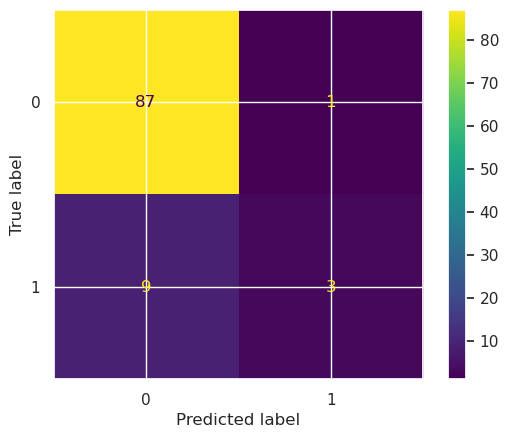

In [36]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(xgbc_reg, X_test, y_test);

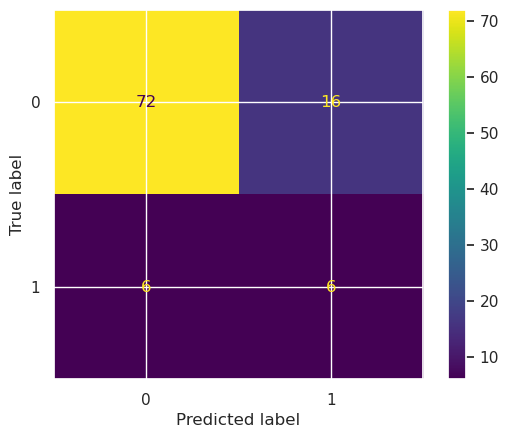

In [37]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(xgbc_under, X_test, y_test);

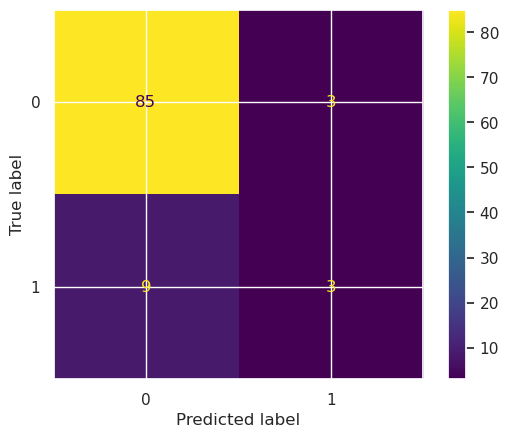

In [38]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(xgbc_over, X_test, y_test);

### Tuning and scaling XGBClassifier
In this section, we will fine-tune and scale XGBClassifier to obtain the best possible recall_score value for the Exoplanets dataset. First, you will adjust weights using scale_pos_weight, then you will run grid searches to find the best combination of hyperparameters. In addition, you will score models for different subsets of the data before consolidating and analyzing the results.

In [39]:
model = XGBClassifier(scale_pos_weight=10, random_state=43)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(score)

[[87  1]
 [ 9  3]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        88
           1       0.75      0.25      0.38        12

    accuracy                           0.90       100
   macro avg       0.83      0.62      0.66       100
weighted avg       0.89      0.90      0.88       100

0.25


The results are the same as our resampling method from the previous section.

The oversampling method that we implemented from scratch gives the same predictions as XGBClassifier with `scale_pos_weight`.

---

We will now embark on a computational experiment to discern if the meticulous adjustment of hyperparameters elevates the precision of our predictive model.

## The Method: Systematic and Stochastic Searches

In the spirit of systematic inquiry, we employ the structured strategy of `GridSearchCV` alongside the serendipitous explorations of `RandomizedSearchCV`. These methods are the dual pathways to fine-tuning, requiring the careful validation through cross-examination of data across multiple folds—a step we have not yet traversed. Our journey has been unhurried, as our initial computational models did not exude the robustness we desired, and the expansive computational landscape of large datasets makes such multiple-fold testing a venture of significant resource expenditure.

## Charting a Balanced Course

With a nod to pragmatism, we shall steer a course that marries efficiency with efficacy: a two-fold cross-validation scheme that conserves time without unduly sacrificing the integrity of our results. In doing so, we heed the counsel of Chapter 6, where the `StratifiedKFold` is the chosen compass, guiding us toward consistent and reliable shores. Thus, armed with this balanced strategy, we prepare to set sail with our baseline model, charting a course toward the yet-unmapped territories of model precision.

In [40]:
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=43)
model = XGBClassifier(scale_pos_weight=10, random_state=43)

scores = cross_val_score(model, X, y_recode, cv=kfold, scoring='recall')

print(f'Recall: {scores}')

print(f'Recall mean: {scores.mean()}')

Recall: [0.10526316 0.11111111]
Recall mean: 0.10818713450292397


`grid_search`

In our `helper_file` we already have a function that does the grid search thingy. It requires a complete dataframe and since XGBoost requires the target to have [0, 1], we will merge the `X` and `y_recode` into a new dataframe, then we pass that into the function.

In [41]:
df_nu = pd.merge(y_recode, X, left_index=True, right_index=True)
df_nu.sample(n=5, random_state=43)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
55,0,247.83,173.35,191.67,169.51,97.43,158.84,138.74,165.53,100.79,...,-25.33,-123.41,-69.55,-24.53,-65.98,-15.65,64.76,26.53,25.25,39.77
271,0,-3.93,3.78,13.18,1.41,1.70,-8.71,7.50,-2.77,-6.80,...,-2.87,4.29,-5.92,-10.97,0.49,0.73,8.06,-7.26,-5.51,1.64
390,0,-186.39,-200.57,-203.37,-207.07,-191.11,-190.57,-240.22,-189.64,-232.90,...,-3.92,-49.79,-21.93,-22.43,-43.06,-3.81,-1.12,-15.82,-24.96,41.64
105,0,67.03,86.02,80.51,96.45,103.42,107.07,118.06,109.17,113.37,...,57.20,61.67,94.63,70.82,53.50,58.02,35.54,20.95,-3.87,38.82
223,0,384.58,385.52,372.67,388.69,365.60,365.18,371.61,347.58,343.12,...,29.64,30.60,24.52,14.60,24.69,41.44,14.11,19.38,30.07,43.20


We will play around with the parameters one after the other.    

In [42]:
grid_search(df_nu, 'LABEL', 
            params={'n_estimators':[50, 200, 400, 800]},
            scoring='recall')

Best params: {'n_estimators': 50}
Best score: 0.19286
search completed!


In [43]:
grid_search(df_nu, 'LABEL', 
            params={'learning_rate':[0.01, 0.05, 0.2, 0.3]}, 
            scoring='recall')

Best params: {'learning_rate': 0.01}
Best score: 0.30000
search completed!


In [44]:
grid_search(df_nu, 'LABEL', 
            params={'max_depth':[1, 2, 4, 8]}, 
            scoring='recall')

Best params: {'max_depth': 1}
Best score: 0.25000
search completed!


In [45]:
grid_search(df_nu, 'LABEL', 
            params={'subsample':[0.3, 0.5, 0.7, 0.9]}, 
            scoring='recall')

Best params: {'subsample': 0.3}
Best score: 0.30000
search completed!


In [46]:
grid_search(df_nu, 'LABEL', 
            params={'gamma':[0.05, 0.1, 0.5, 1]}, 
            scoring='recall')

Best params: {'gamma': 1}
Best score: 0.25000
search completed!


In [47]:
grid_search(df_nu, 'LABEL', 
            params={'learning_rate':[0.001, 0.01, 0.03], 
                    'max_depth':[1, 2], 
                    'gamma':[0.025, 0.05, 0.5],
                   'subsample':[0.3, 0.5, 0.7, 0.9]}, 
            scoring='recall')

Best params: {'gamma': 0.025, 'learning_rate': 0.01, 'max_depth': 2, 'subsample': 0.9}
Best score: 0.19643
search completed!


In [48]:
grid_search(df_nu, 'LABEL', 
            params={'max_delta_step':[1, 3, 5, 7]}, 
            scoring='recall')

Best params: {'max_delta_step': 1}
Best score: 0.16786
search completed!


In [49]:
grid_search(df_nu, 'LABEL', 
            params={'subsample':[0.3, 0.5, 0.7, 0.9, 1],
                    'colsample_bylevel':[0.3, 0.5, 0.7, 0.9, 1],
                    'colsample_bynode':[0.3, 0.5, 0.7, 0.9, 1],
                    'colsample_bytree':[0.3, 0.5, 0.7, 0.9, 1]}, 
            random=True, scoring='recall')

Best params: {'subsample': 0.3, 'colsample_bytree': 0.9, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.5}
Best score: 0.30357
search completed!


We will try again with the undersampler

In [50]:
under_sampler = RandomUnderSampler(random_state=43)
X_under, y_under = under_sampler.fit_resample(X, y_recode)
print(X_under.shape)
X_under.head()

(74, 3197)


,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
180,45.79,31.21,30.88,2.67,24.23,28.71,26.08,14.79,15.62,-10.47,...,11.54,4.71,2.09,19.87,26.34,20.15,-13.42,-1.13,7.06,3.82
376,3.44,-1.95,10.86,23.80,-13.22,-7.97,-5.68,-4.77,-14.46,-12.24,...,-0.39,20.19,3.30,12.40,-0.23,-10.79,-5.63,-1.60,-12.25,-7.48
385,235.11,201.36,190.27,167.24,144.70,124.22,112.22,102.16,73.46,73.26,...,55.37,44.95,41.99,30.93,37.63,41.66,12.20,23.27,45.33,68.51
324,-16.67,-9.74,-0.20,11.57,7.91,-16.01,-15.01,-2.40,5.53,-9.91,...,-5.46,9.27,-6.73,-4.45,-10.79,5.73,-56.47,-14.44,-10.82,-16.67
265,-327.91,-280.43,-306.35,-297.06,-333.77,-320.66,-308.61,-341.64,-336.01,-350.67,...,5.89,13.60,37.08,-10.53,-23.38,15.02,18.08,31.13,33.56,33.29


In [51]:
df_under = pd.merge(y_under, X_under, left_index=True, right_index=True)
df_under.sample(n=5, random_state=43)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
19,1,560.19,262.94,189.94,185.12,210.38,104.19,289.56,172.06,81.75,...,106.00,-7.94,-7.94,-7.94,52.31,-165.00,7.38,-61.56,-44.75,104.50
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
25,1,304.50,275.94,269.24,248.51,194.88,167.80,139.13,149.36,100.97,...,4.21,3.53,-5.13,14.56,-1.44,-10.73,3.49,0.18,-2.89,40.34
29,1,31.29,25.14,36.93,16.63,17.01,-7.50,0.09,1.24,-19.82,...,11.36,12.96,28.50,51.05,25.85,4.79,13.26,-17.58,13.79,0.72


In [52]:
grid_search(df_under, 'LABEL', 
            params={'max_depth':[1, 2, 3],
                    'colsample_bynode':[0.5, 0.75, 1]},
            scoring='recall')

Best params: {'colsample_bynode': 0.5, 'max_depth': 3}
Best score: 0.76071
search completed!


This is a massive jump!

### Fine-tuning all the data
Time to fine tune all the data that we have got.

In [53]:
with ZipFile(url, 'r') as z:
    with z.open(z.namelist()[0]) as f:
        df_all = pd.read_csv(f)

df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


This next cell shows how to consider the XGBoost quirk of only preferring to work with [0,1] for binary classifications.

In [54]:
df_all = (
    df_all
    .assign(LABEL = df_all['LABEL'].replace({1: 0, 2: 1}))
)
df_all['LABEL'].value_counts()

LABEL
0    5050
1      37
Name: count, dtype: int64

Scale the weights by dividing the negative class by the positive class.

In [55]:
weight = int(df_all['LABEL'].value_counts()[0]/df_all['LABEL'].value_counts()[1])
weight

136

Split the data into X and y

In [56]:
X_all, y_all = splitX_y(df_all, 'LABEL')

Score a baseline model for all the data with XGBClassifier and `scale_pos_weight=weight`.

In [57]:
model = XGBClassifier(scale_pos_weight=weight, random_state=43)

scores = cross_val_score(model, X_all, y_all, cv=kfold, scoring='recall')

print(f'Recall: {scores}')

print(f'Recall mean: {scores.mean()}')

Recall: [0. 0.]
Recall mean: 0.0


This score is really awful. Presumably, the classifier is scoring a high percentage of accuracy, despite the low recall.

Let's try optimizing hyperparameters based on the most successful results thus far.

In [58]:
grid_search(df_all, 'LABEL', 
            params={'max_depth':[1, 2],
                    'learning_rate':[0.001]},
            scoring='recall', weight=weight)

Best params: {'learning_rate': 0.001, 'max_depth': 1}
Best score: 0.54643
search completed!


Let us ponder the recent empirical findings with a measure of both curiosity and skepticism. Our latest venture, although surpassing the unmodified expanse of data, does not quite reach the statistical heights achieved by our earlier experiment, wherein the data was meticulously undersampled.

**The Paradox of Scale and Time**

As we embark on this analytical journey, we are confronted with an intriguing conundrum: the full dataset, while comprehensive, yields a lower score and demands a greater temporal investment for computational processing. This observation beckons the question — do our algorithmic creations truly excel when confined to the more diminutive realms of our Exoplanet dataset?

**The Quest for Empirical Truth**

To unravel this mystery, we must proceed with a methodical comparison. Let us delve into the depths of this dataset, and like Feynman, "find out" by testing our models on these smaller subsets. It is through this rigorous scientific exploration that we shall uncover the veracity of our models' proficiency.

The following function takes X, y, and the chosen params as input. The model is fit on the data provided, then predictions are made on the entire dataset. Finally, `recall_score`, `confusion matrix`, and `classification report` are all printed.

In [63]:
def final_model(df, target, params):

    X, y = splitX_y(df, target)
    model = XGBClassifier(**params)
    model.fit(X, y)

    y_pred = model.predict(X_all)

    score = recall_score(y_all, y_pred,)

    print(score)

    print(confusion_matrix(y_all, y_pred,))

    print(classification_report(y_all, y_pred))

In [66]:
params = {
    'max_depth': 2,
    'colsample_bynode': 0.5,
    'random_state': 43
}

In [67]:
final_model(df_under, 'LABEL', params=params)

1.0
[[3837 1213]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      5050
           1       0.03      1.00      0.06        37

    accuracy                           0.76      5087
   macro avg       0.51      0.88      0.46      5087
weighted avg       0.99      0.76      0.86      5087



In an endeavor and insatiable appetite for uncovering the truths of the cosmos, we've cast our computational net into the celestial ocean, only to haul in a catch brimming with false stars. Our algorithm, with an eagle-eyed focus on recall, has indeed snared all 37 elusive exoplanets. Yet, amidst our triumph, a stark revelation emerges: 1,213 stars of no remarkable exoplanetary significance have been ensnared in our celestial dragnet—a false promise of worlds that were not to be.

**The Precision Predicament**

Our pursuit, while noble in its aim for completeness, has wielded a tool of 100% recall yet a meager precision of 3%. The resultant F1 score—a paltry 6%—stands as a testament to the inherent peril of a solitary fixation on recall. Feynman would likely muse that in the grand tapestry of the cosmos, the beauty of a single thread lies in its interweaving with others. Precision, too, must dance in harmony with recall to compose the opus of discovery.

**The Astronomer's Quandary**

Imagine the plight of the astronomer, who, under the guidance of our current model, must sift through a haystack of 1,213 potential exoplanet stars to uncover the 37 needles of truth. This scenario, while rich in potential, is marred by inefficiency—an astronomer's odyssey turned Sisyphean task.

**The Path Forward**

In the indomitable spirit of inquiry, we must now turn to a new chapter. What secrets will be unveiled when we temper our algorithmic forge with a mere 400 rows of data? As we continue this computational voyage, each step brings us closer to the harmonious balance that eludes us still—the perfect equilibrium between recall and precision, the yin and yang of celestial discovery.

In [70]:
df = (
    df
    .assign(LABEL = df['LABEL'].replace({1: 0, 2: 1}))
)
df['LABEL'].value_counts()

LABEL
0    363
1     37
Name: count, dtype: int64

In [71]:
params = {
    'max_depth': 2,
    'colsample_bynode': 0.5,
    'scale_pos_weight': 10,
    'random_state': 43
}

final_model(df, 'LABEL', params=params)

1.0
[[4888  162]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      5050
           1       0.19      1.00      0.31        37

    accuracy                           0.97      5087
   macro avg       0.59      0.98      0.65      5087
weighted avg       0.99      0.97      0.98      5087



In our quest, our computational telescope has once again locked onto all 37 exoplanet stars with unwavering accuracy, achieving a stellar recall of 100%. Yet, our celestial celebration is tempered by the realization that 162 ordinary stars have been mislabeled as harbingers of new worlds.

**A Step Towards Astronomical Precision**

This recent foray, while still encumbered with the weight of error, marks a notable improvement. Precision has climbed to 19%—a significant leap from the previous 3%. An astronomer, armed with this refined model, would now traverse a field of 186 stars to find the 37 exoplanet stars. Though the journey remains arduous, it is considerably less so than before.

**The Astronomical Implication**

While we have yet to perfect our cosmic sieve—our ability to separate exoplanet wheat from chaff—the path to improvement is illuminated with the light of data. The ratio of chaff to wheat has diminished, and thus the task of the astronomer, while not effortless, is less Sisyphean than it once was.

**The Next Frontier**

As we stand on the precipice of the known, ready to dive into the vast ocean of data that encompasses all, we prepare to train our algorithmic eyes on the full expanse of the stars. What truths will we uncover when the full canvas of the cosmos is laid bare before our computational might? Let us proceed, to unearth the secrets woven into the very fabric of the universe.

In [72]:
params = {
    'max_depth': 2,
    'colsample_bynode': 0.5,
    'scale_pos_weight': weight,  
    'random_state': 43
}


In [73]:
final_model(df_all, 'LABEL', params=params)

1.0
[[5050    0]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5050
           1       1.00      1.00      1.00        37

    accuracy                           1.00      5087
   macro avg       1.00      1.00      1.00      5087
weighted avg       1.00      1.00      1.00      5087



**The Model's Stellar Performance on Familiar Grounds**

In a rather striking outcome, our model has achieved the celestial jackpot: a perfect score in both recall and precision. It's as if every star in our computational sky has aligned, granting the astronomer the luxury of a flawless map to exoplanetary treasures without the interference of cosmic clutter.

**The Caveat of Overfitting**

Yet, in the quest for cosmic truth, one must not be swayed by a mirage of perfection within the training grounds. True validation lies in the model's prowess when faced with the unknown—unseen test data, the ultimate arbiter of a model's strength. A perfect fit for the training set can often be an illusion, a siren's song luring us away from the reality of generalization.

**Insights from the Depths of Data**

The journey through the data reveals a spectrum of precision. Here's what the stars tell us:

**The Harmony of Metrics**

Leaning on a single metric can steer us into astronomical anomalies. Precision, recall, and the F1 score must be conjured together, much like a constellation, to guide us to optimal models.

**The Perils of Small Samples**

Caution is advised against overvaluing high scores from mere slivers of datasets.

**The Call for Deeper Analysis**

An imbalanced dataset where training outshines testing suggests a dive into the complex cosmos of hyperparameter tuning.

A survey of Kaggle's shared notebooks unveils a common oversight: the allure of high accuracy in a skewed dataset can be deceptive.

**Conclusions for the Cosmic Scholar**

Presenting to the mentor of the skies, one must acknowledge the limitations imposed by imbalanced celestial data. A model's true performance, perhaps a modest 70% recall, is a sobering reminder of the vastness we seek to understand. And while 37 exoplanet stars are but a small step in our odyssey, the XGBClassifier is our telescope, guiding astronomers and data savants alike in the grand quest to pinpoint the next exoplanetary discovery.